## 1-head self-attention implementation

In [ ]:
%pip install datasets nltk
%pip install -q tokenizers
%pip install -U portalocker>=2.0.0

# https://pypi.org/project/torchtext/

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Data preparation

In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb")
train_data, test_data = imdb['train'], imdb['test']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase

hf_tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
hf_tokenizer.normalizer = Lowercase()
hf_tokenizer.pre_tokenizer = Whitespace()

vocab_limit = 20000
min_freq = 3

trainer = WordLevelTrainer(
    vocab_size=vocab_limit,
    min_frequency=min_freq,
    special_tokens=["<pad>", "<s>", "<unk>"]
)


hf_tokenizer.train_from_iterator((x["text"] for x in train_data), trainer)

vocab = hf_tokenizer.get_vocab()
vocab_ordered = dict(sorted(vocab.items(), key=lambda x: x[1]))

PAD_ID = hf_tokenizer.token_to_id("<pad>")
SOS_ID = hf_tokenizer.token_to_id("<s>")
UNK_ID = hf_tokenizer.token_to_id("<unk>")

vocab_size = len(vocab_ordered)

print("HF vocab_size =", vocab_size)
print("SPECIAL:", {"<pad>": PAD_ID, "<s>": SOS_ID, "<unk>": UNK_ID})


HF vocab_size = 20000
SPECIAL: {'<pad>': 0, '<s>': 1, '<unk>': 2}


In [ ]:
import torch

seq_length = 200

def text_pipeline(text: str):
    return hf_tokenizer.encode(text).ids

def collate_batch(batch, seq_length=seq_length):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample["label"])

        ids = text_pipeline(sample["text"])[:seq_length]

        if len(ids) < seq_length:
            pad_size = seq_length - len(ids) - 1
            ids = [PAD_ID] * pad_size + [SOS_ID] + ids

        text_list.append(ids)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return (input_ids, labels)


In [ ]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

# 2. Model

In [ ]:
class MyMultiheadAttention(nn.Module):
    def __init__(self, embed_dim):
        super(MyMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim

    def forward(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.embed_dim ** 0.5)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, value)

        return output

class TransformerTextCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, dropout, device):
        super().__init__()
        self.word_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.attn = MyMultiheadAttention(embed_dim=embed_dim)
        self.fc = nn.Linear(in_features=200*32, out_features=2)

    def forward(self, x):
        output = self.word_emb(x)
        query, key, value = output, output, output
        attn_output = self.attn(query, key, value)
                    # (32,200 token) -> embeded (32, 200, 32) ->
            # MyMultiheadAttention(wq(32,32) wk (32,32) wv(32,32)->q(32,200,32)k(32,200,32)v(32,2000,32) scores(32,200,200), attentionweight (32,200,200) -> output->(32, 200,32))

        output = nn.Flatten()(output) -> 200*32
        output = self.fc(output) #(2,)
        return output

In [ ]:
batch_size = 32
max_length = seq_length #200
embed_dim = 32
ff_dim = 32
dropout = 0.1
model = TransformerTextCls(vocab_size, max_length, embed_dim, dropout, device)

# (32,200 token) -> embeded (32, 200, 32) -> MyMultiheadAttention(wq(32,32) wk (32,32) wv(32,32)->q(32,2000,32)k(32,2000,32)v(32,2000,32) scores(32,2000,2000), attentionweight (32,2000,2000) -> output->(32, 2000,32))->

# 3. Evaluate

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            #(32,2)- (32,2)= (32,2)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1) #dim=1 là lấy từng hàng tính max  (32,2)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

# 4. Train

In [ ]:
max_epoch = 15
LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/15], Loss: 0.9024, Accuracy: 56.25%, Test Loss: 0.9417, Test Accuracy: 59.89%
Epoch [2/15], Loss: 0.6544, Accuracy: 71.98%, Test Loss: 0.8278, Test Accuracy: 66.90%
Epoch [3/15], Loss: 0.4721, Accuracy: 80.48%, Test Loss: 0.8036, Test Accuracy: 71.03%
Epoch [4/15], Loss: 0.3357, Accuracy: 86.53%, Test Loss: 0.8594, Test Accuracy: 72.35%
Epoch [5/15], Loss: 0.2327, Accuracy: 91.17%, Test Loss: 1.0123, Test Accuracy: 71.73%
Epoch [6/15], Loss: 0.1518, Accuracy: 94.31%, Test Loss: 1.0183, Test Accuracy: 73.70%
Epoch [7/15], Loss: 0.0872, Accuracy: 97.01%, Test Loss: 1.0782, Test Accuracy: 74.38%
Epoch [8/15], Loss: 0.0499, Accuracy: 98.54%, Test Loss: 1.1644, Test Accuracy: 74.21%
Epoch [9/15], Loss: 0.0297, Accuracy: 99.23%, Test Loss: 1.2460, Test Accuracy: 74.34%
Epoch [10/15], Loss: 0.0238, Accuracy: 99.38%, Test Loss: 1.3428, Test Accuracy: 74.63%
Epoch [11/15], Loss: 0.0127, Accuracy: 99.78%, Test Loss: 1.3891, Test Accuracy: 74.96%
Epoch [12/15], Loss: 0.0061, Accuracy: 99

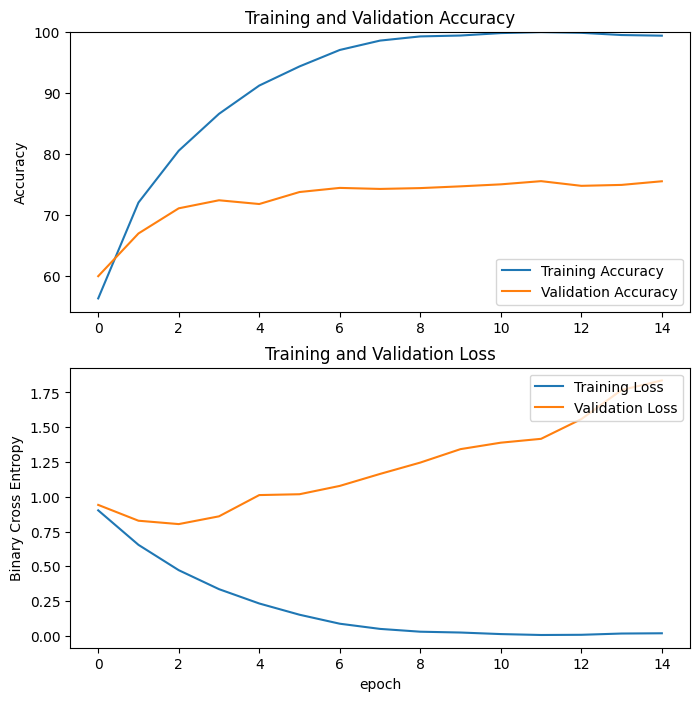

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()